<a href="https://colab.research.google.com/github/yjchoi1/liq_rnn_modules/blob/main/notebook_with_modules_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/2021-LSTM-Liquefaction/Data/Code_yc2_with_modules')

In [ ]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf 

import cssData
import prepareData
from matplotlib import pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 19:09:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# %% import data ad dataframe

data_dir = "/content/drive/MyDrive/2021-LSTM-Liquefaction/Data/liq_data"  # get the data folder path
expNumList1 = cssData.expNumList()  # get expNumList that you want to consider
Drs = cssData.relativeDensity()  # get relative density (Dr) data for each trial

# get dataframe for all trials
df_all = cssData.to_dataframe(data_dir=data_dir, expNumList=expNumList1, Drs=Drs)

In [ ]:
Drs

[array([0.55, 0.54, 0.47, 0.56, 0.52, 0.52, 0.39, 0.52, 0.41, 0.43, 0.39,
        0.39, 0.33, 0.35, 0.43, 0.35, 0.41, 0.44, 0.53]),
 array([0.76, 0.94, 0.89, 0.77, 0.72, 0.73, 0.85, 0.88, 0.9 , 0.74]),
 array([0.41, 0.47, 0.47, 0.4 , 0.39, 0.43, 0.41, 0.49, 0.41, 0.37, 0.44,
        0.47, 0.48, 0.44, 0.5 , 0.47, 0.51, 0.48, 0.5 , 0.5 , 0.4 , 0.44,
        0.44, 0.45, 0.41, 0.44, 0.43, 0.41, 0.43, 0.37, 0.42, 0.43, 0.36,
        0.5 , 0.42, 0.45, 0.49, 0.43, 0.39, 0.43, 0.47, 0.48, 0.55, 0.44,
        0.49, 0.41, 0.55]),
 array([0.78, 0.72, 0.84, 0.79, 0.82, 0.86, 0.89, 0.74, 0.7 , 0.74, 0.8 ,
        0.78, 0.89, 0.84, 0.89, 0.84, 0.81, 0.83, 0.91, 0.86, 0.78, 0.73,
        0.72, 0.71, 0.76, 0.8 , 0.73, 0.74, 0.73])]

In [ ]:
# look into data
cssData.LookIntoData(dataframe=df_all, timeIndex=1000)

Experiment7----------------------------------------
*Trial-1
last index and time:11013, 163.816; interval: 0.0149
1000 time step is: 12.704 sec
*Trial-2
last index and time:10220, 154.766; interval: 0.0151
1000 time step is: 12.704 sec
*Trial-3
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-4
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-5
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-6
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-7
last index and time:9399, 144.05200000000002; interval: 0.0153
1000 time step is: 12.704 sec
*Trial-8
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-9
last index and time:8659, 109.99799999999999; interval: 0.0127
1000 time step is: 12.704 sec
*Trial-10
last index and time:8659, 109.9979999999

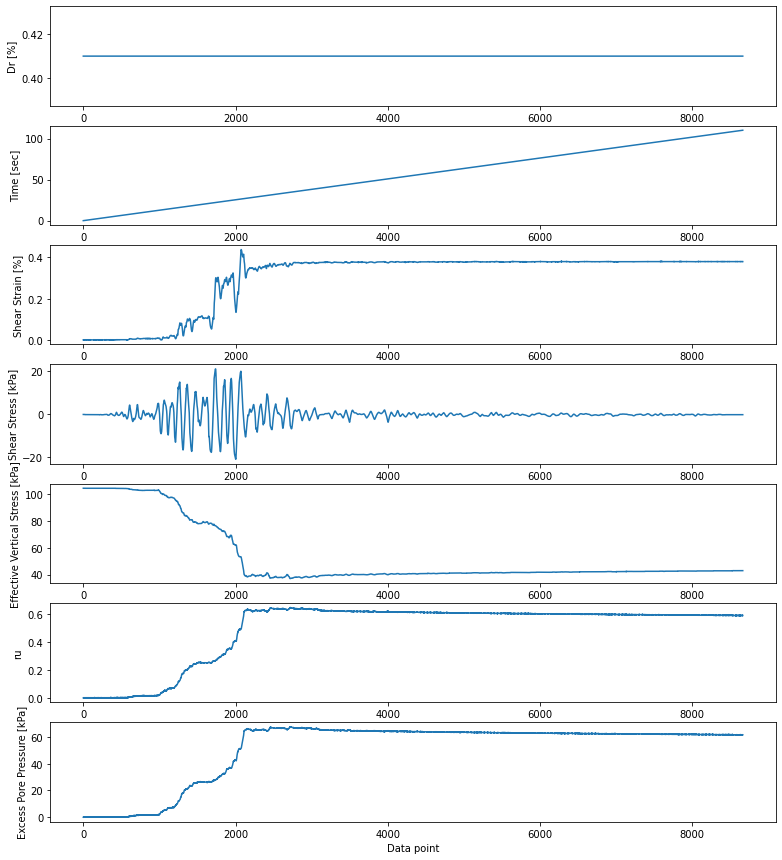

In [ ]:
# plot trial
cssData.plotTrial(dataframe=df_all, expIndex=2, trialIndex=0)

In [ ]:
# see columns in the raw dataframe
df_all[0][0].columns

Index(['Time [sec]', 'Dr [%]', 'Shear Stress [kPa]', 'ru'], dtype='object')

In [ ]:
# %% reshape dataframe

# select columns and length and cut the dataframe to the form you what to get
selectCols = ['Time [sec]', 'Shear Stress [kPa]', 'ru']
time_steps = 8600
df_cut = prepareData.cutDataFrame(time_steps=8600, cols=selectCols, dataframe=df_all)

In [ ]:
# %% Train and test split

# choose your exp and trial index to use.
# for i in expIndex; for j in trialIndex, i and j iterate.
# for example, expIndex=[0, 1], trialIndex=[[0,1], [0, 1, 3]],
# the result indices are (0,0) (0, 1), (1, 0), (1, 1), (1, 3).
expIndex_train = [0, 1]
trialIndex_train = [[0, 1, 6, 10, 11, 12, 13, 14], [0, 2, 4, 5]]
expIndex_test = [0, 1]
trialIndex_test = [[15, 13], [6]]

# The method `prepareData.data_array` also returns the index of (exp, trial).
# This will be used to define the title of result plots.
data_array_train, train_trial_index = prepareData.data_array(
    expIndex=expIndex_train, trialIndex=trialIndex_train, df_cut=df_cut)
data_array_test, test_trial_index = prepareData.data_array(
    expIndex=expIndex_test, trialIndex=trialIndex_test, df_cut=df_cut)

In [ ]:
# %% normalize the data (only selected cols)

# The best practice is to normalize train & test separately to prevent data leak
# The method `prepareData.normalize_cols` also returns the normalization factors.
# These might be used to denormalize the data back to the original values.
colsToConsider = [0, 1]  # 0: time, 1:stress, 2: ru
data_array_train_normalized, normalizingFactors_train = prepareData.normalize_cols(
    data_array=data_array_train, cols_to_normalize=colsToConsider)
data_array_test_normalized, normalizingFactors_test = prepareData.normalize_cols(
    data_array=data_array_test, cols_to_normalize=colsToConsider)

In [ ]:
# %% set x and y

# inputs
features = [0, 1]  # 0: time, 1: stress
target = [2]  # 2: ru

# split x and y for train and test, from the data_array
x_array_train = data_array_train_normalized[:, :, features]
y_array_train = data_array_train_normalized[:, :, target]
x_array_test = data_array_test_normalized[:, :, features]
y_array_test = data_array_test_normalized[:, :, target]

In [ ]:
# %% make data for time-series input for RNN layers (time window method)
length = 400

x_rnn_train, y_rnn_train, x_rnn_test, y_rnn_test = prepareData.windowDataset(
    x_array_train, y_array_train, x_array_test, y_array_test, length, time_steps
)

In [ ]:
# %% shuffle

shuffler = np.random.permutation(len(x_rnn_train))  # get indices for shuffling
x_rnn_train_sf = x_rnn_train[shuffler]  # shuffle the dataset
y_rnn_train_sf = y_rnn_train[shuffler]  # shuffle the dataset

In [ ]:
# %% build a model

# now build the RNN
model = Sequential()
# model.add(LSTM(32, input_shape=(data_mat_3d_final.shape[1],
#           data_mat_3d_final.shape[2]), activation='tanh'))  # tanh
model.add(LSTM(128, return_sequences=True, input_shape=(x_rnn_train.shape[1],
          x_rnn_train.shape[2]), activation='tanh'))  # tanh
# model.add(Dropout(0.1))
model.add(LSTM(128, activation='tanh'))  # tanh
# model.add(Dropout(0.1))
model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))
model.add(Dense(16, activation='tanh'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))

# monitor validation progress
early = EarlyStopping(monitor="val_loss", mode="min", patience=1000)
callbacks_list = [early]

# set optimizer
opt = tf.optimizers.Adam(learning_rate=0.001)  # default learning rate=0.001

#########################
loss = ['mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error']
metrics = ['mse','mape','mae']

choose_loose = 0
model.compile(loss=loss[choose_loose],
              optimizer=opt,
              metrics=metrics[choose_loose])
#########################

# Show a model summary table
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 400, 128)          67072     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 207,969
Trainable params: 207,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

# %% train

# train with batch
history = model.fit(x_rnn_train_sf, y_rnn_train_sf,
                    epochs=25, batch_size=32, verbose=2,
                    validation_split=0.20,
                    callbacks=callbacks_list,
                    shuffle=True)

Epoch 1/25
2460/2460 - 112s - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0515 - val_mse: 0.0515 - 112s/epoch - 45ms/step
Epoch 2/25
2460/2460 - 111s - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0358 - val_mse: 0.0358 - 111s/epoch - 45ms/step
Epoch 3/25
2460/2460 - 111s - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0235 - val_mse: 0.0235 - 111s/epoch - 45ms/step
Epoch 4/25
2460/2460 - 111s - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0093 - val_mse: 0.0093 - 111s/epoch - 45ms/step
Epoch 5/25
2460/2460 - 111s - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0055 - val_mse: 0.0055 - 111s/epoch - 45ms/step
Epoch 6/25
2460/2460 - 111s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0036 - val_mse: 0.0036 - 111s/epoch - 45ms/step
Epoch 7/25
2460/2460 - 111s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0044 - 111s/epoch - 45ms/step
Epoch 8/25
2460/2460 - 110s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0037 - val_mse: 0.0037 - 110s/epoch - 45ms/step
Epoch 9/25
2460/2460 - 111s - loss: 0.0027 - mse

Text(0, 0.5, 'mse')

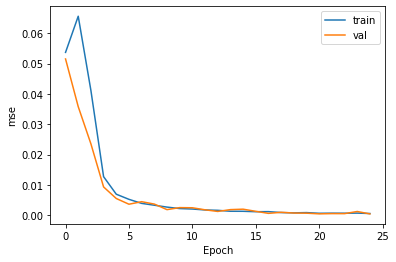

In [ ]:
# plot model training history

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel(metrics[choose_loose])

In [ ]:
# %% get predictions

# Note that the model is trained with shuffled data, ...
# while the prediction is done with unshuffled data.
y_rnn_train_pred = model.predict(x_rnn_train)
y_rnn_test_pred = model.predict(x_rnn_test)

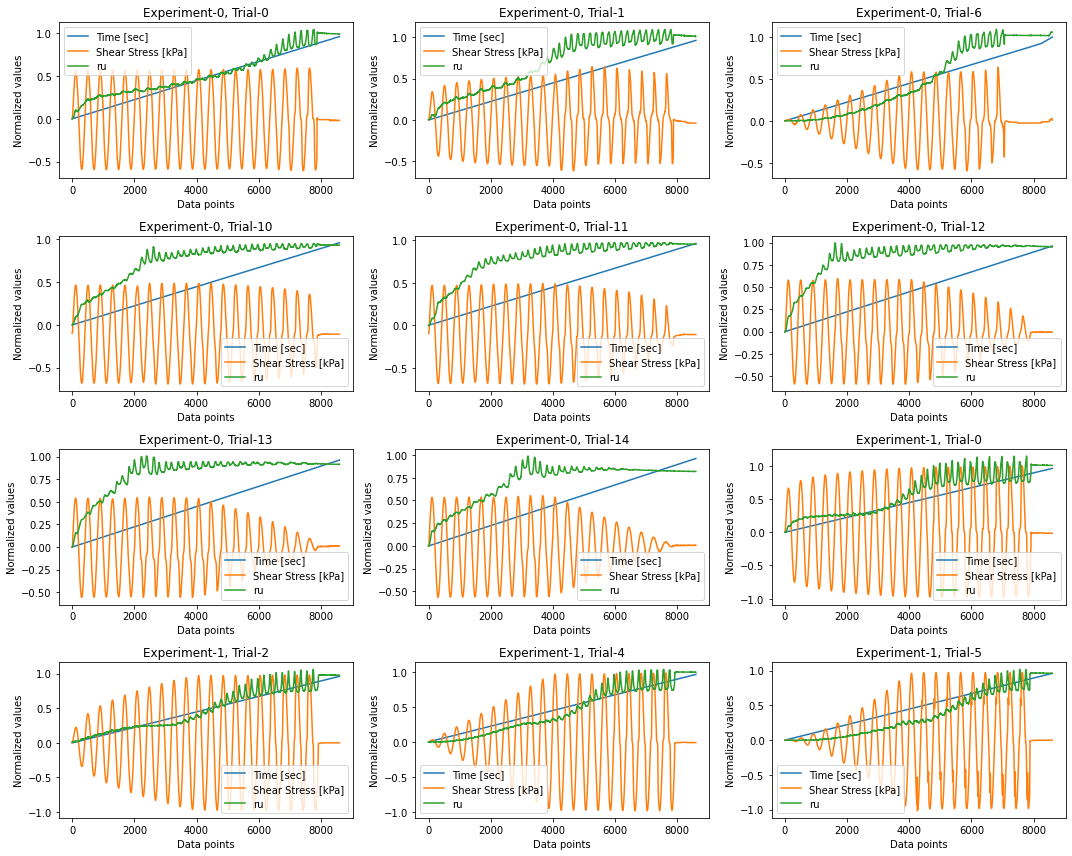

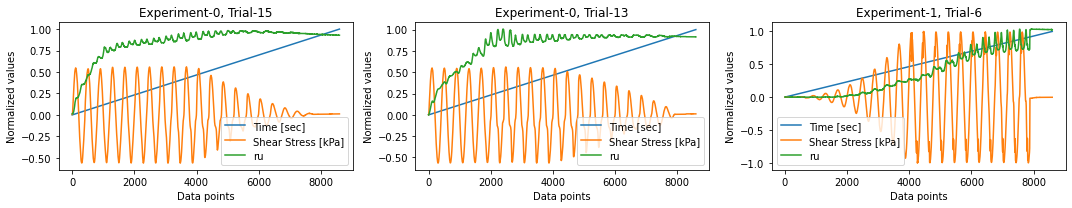

In [ ]:
#%% plot x_array and y_array

import plotResult

inputData = plotResult.plot_dataset(
    x_array=x_array_train, y_array=y_array_train,
    title_index=train_trial_index, legends=selectCols)

testData = plotResult.plot_dataset(
    x_array=x_array_test, y_array=y_array_test,
    title_index=test_trial_index, legends=selectCols)

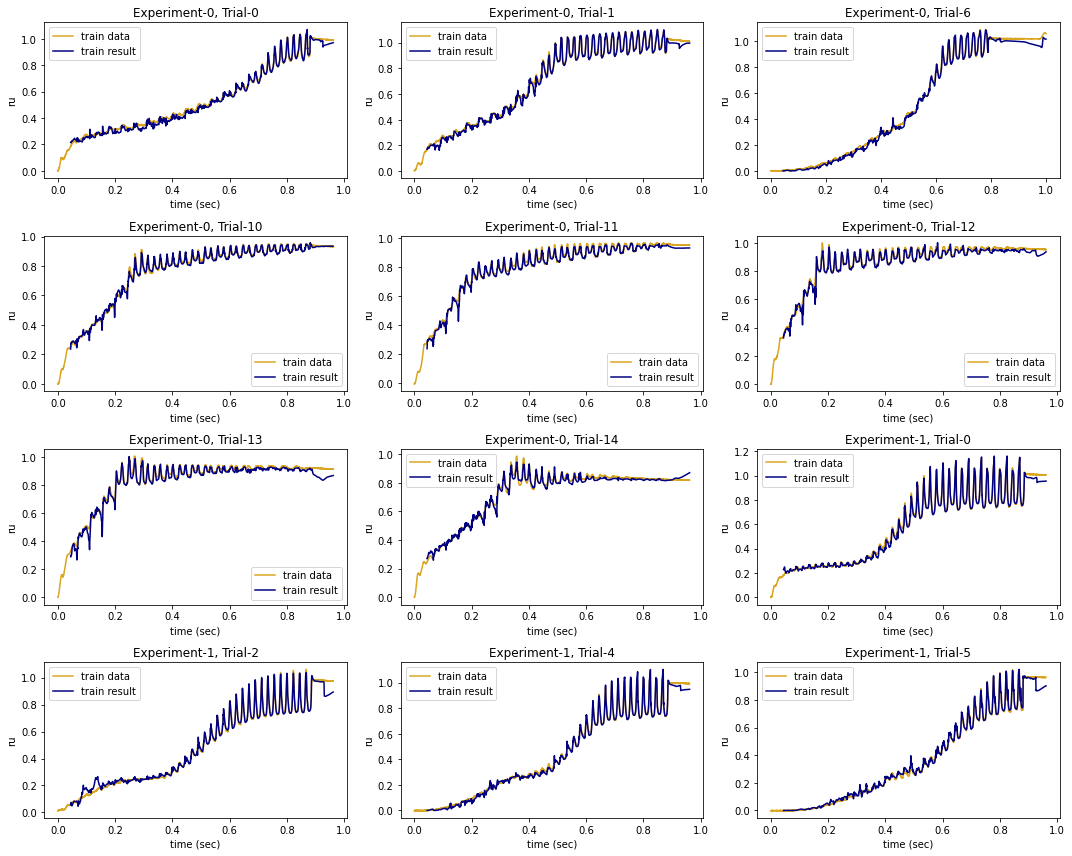

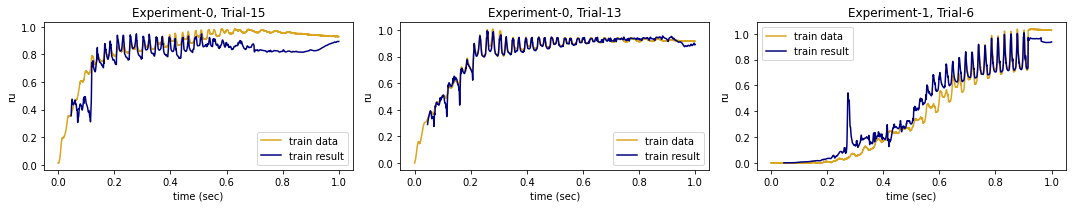

In [ ]:
#%% plot training and prediction result
trainResult = plotResult.plot_predictionResult(
    x_array_sample=x_array_train, y_array_sample=y_array_train, y_rnn_pred=y_rnn_train_pred,
    time_steps=time_steps, window_length=length,
    title_index=train_trial_index)

trainResult = plotResult.plot_predictionResult(
    x_array_sample=x_array_test, y_array_sample=y_array_test, y_rnn_pred=y_rnn_test_pred,
    time_steps=time_steps, window_length=length,
    title_index=test_trial_index)

In [ ]:
from sklearn.metrics import mean_squared_error
  
# Given values
Y_true = y_rnn_test  # Y_true = Y (original values)
  
# calculated values
Y_pred = y_rnn_test_pred  # Y_pred = Y'
  
# Calculation of Mean Squared Error (MSE)
mean_squared_error(Y_true,Y_pred)

0.0057088521393299525

# Delete